In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm

In [3]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [4]:
!nvidia-smi

Sun Oct 13 21:12:00 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.116                Driver Version: 390.116                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P8    14W / 250W |    262MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
torch.cuda.set_device(0)

In [6]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-hindi/language-model


In [7]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-hindi/language-model')

In [9]:
# train_files, test_files = train_test_split(files, test_size=0.2)

In [10]:
# len(train_files), len(test_files)

In [11]:
# str(train_files[0]).split('/')[-1][:-4]

In [12]:
# # Preparing dataset for fastai
# for file in train_files:
#     with open(file, 'rb') as f:
#         text = pickle.load(f)
#     with open(path/'hindi_transformer'/'train'/(str(file).split('/')[-1][:-4]+'.txt'), "w") as text_file:
#         text_file.write(text)

In [13]:
# for file in test_files:
#     with open(file, 'rb') as f:
#         text = pickle.load(f)
#     with open(path/'hindi_transformer'/'valid'/(str(file).split('/')[-1][:-4]+'.txt'), "w") as text_file:
#         text_file.write(text)

In [14]:
# from inltk.tokenizer import HindiTokenizer

In [15]:
# HindiTokenizer

In [10]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-hindi/language-model')

In [11]:
class HindiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/hindi_lm_large.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [12]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/hindi_lm_large.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [13]:
len(itos)

30000

In [14]:
itos[:20]

['<unk>',
 '<s>',
 '</s>',
 '▁के',
 '।',
 '▁में',
 '▁है',
 ',',
 '▁की',
 '▁',
 '▁और',
 '▁से',
 '▁का',
 '▁को',
 '▁हैं',
 '▁एक',
 '▁पर',
 '.',
 '-',
 '▁ने']

In [15]:
# 30,000 is the vocab size that we chose in sentencepiece
hindi_vocab = Vocab(itos)

In [16]:
tokenizer = Tokenizer(tok_func=HindiTokenizer, lang='hi')

In [17]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [18]:
data_lm = TextLMDataBunch.from_folder(path=path/'HindiDataset', tokenizer=tokenizer, vocab=hindi_vocab)

In [19]:
data_lm.batch_size

64

In [42]:
data_lm.save()

In [20]:
data_lm.show_batch()

idx,text
0,"▁भारतीय ▁धातुकर्म ▁की ▁पराकाष्ठा ▁है । ▁यह ▁कथित ▁रूप ▁से ▁राजा ▁चन्द्रगुप्त ▁विक्रमादित्य ▁से ▁निर्माण ▁कराया ▁गया , ▁किंतु ▁कुछ ▁विशेषज्ञों ▁का ▁मानना ▁है ▁कि ▁इसके ▁पहले ▁निर्माण ▁किया ▁गया , ▁संभवतः ▁9 12 ▁ईपू ▁में । ▁स्तंभ ▁की ▁उँचाई ▁लगभग ▁सात ▁मीटर ▁है ▁और ▁पहले ▁हिंदू ▁व ▁जैन ▁मंदिर ▁का ▁एक ▁हिस्सा ▁था । ▁तेरहवीं ▁सदी ▁में ▁कुतुबुद्दीन ▁ऐबक ▁ने ▁मंदिर ▁को ▁नष्ट ▁करके ▁क़ुतुब ▁मीनार ▁की ▁स्थापना ▁की"
1,"▁की ▁विस्तृत ▁तालिका ▁देना ▁सर्वथा ▁असंभव ▁है ▁जिन ▁दशाओं ▁में ▁उच्च ▁न्यायालय ▁अपनी ▁शक्ति ▁का ▁प्रयोग ▁करना ▁अस्वीकार ▁कर ▁सकता ▁है । ▁प्रत्येक ▁मामले ▁की ▁परिस्थिति , ▁प्रकृति ▁उद्देश्य ▁तथा ▁शक्ति ▁के ▁विस्तार य ▁को ▁दृष्टिगत ▁रखकर ▁ही ▁न्यायालय ▁अपने ▁न्यायिक ▁विवेक ▁का ▁प्रयोग ▁करेगा । ▁सामान्यत : ▁मामले ▁से ▁प्रत्यक्ष ▁रूप ▁ते ▁सम्बन्धित ▁व्यक्ति ▁ही ▁सर्वोच्च ▁न्यायालय ▁अथवा ▁उच्च ▁न्यायालयों ▁से ▁उनकी ▁शक्ति ▁के ▁प्रयोग ▁की ▁याचना ▁कर ▁सकता"
2,"▁आमतौर ▁पर ▁इस्तेमाल ▁किए ▁जाने ▁वाले ▁पौधे ▁और ▁पशुओं ▁के ▁नाम ▁को ▁ट क्स ा ▁कभी - कभी ▁इन ▁जातियों ▁के ▁समान ▁होते ▁हैं : ▁जैसे , ▁"" शेर "", ▁"" वॉल रस , "" ▁और ▁"" क पूर ▁का ▁पेड़ "" ▁- ▁प्रत्येक ▁जातियों ▁को ▁दर्शाते ▁हैं । ▁अन्य ▁मामले ▁जिनमें ▁उन ▁नाम ▁का ▁प्रयोग ▁नहीं ▁होता : ▁"" हिर ण "" ▁34 ▁जातियों ▁के ▁वर्ग ▁को ▁दर्शाता ▁है"
3,"▁मूल ▁क्षेत्र ▁दक्षिण ▁पूर्वी ▁एशिया के ▁बाहर ▁दुर्लभ ▁होने ▁कि ▁वजह ▁से ▁अधिकांश ▁लोग ▁लाइक ोप ीन ▁के ▁लिए ▁आहार ▁के ▁मुख्य ▁स्रोत ▁के ▁तौर ▁पर ▁अर्थात् ▁85% ▁से ▁अधिक ▁टमाटर ▁और ▁टमाटर ▁आधारित ▁सॉ स , ▁जू स ▁और ▁के च प ▁का ▁सेवन ▁करते ▁हैं । ▁टमाटर ▁में ▁लाइक ो पेन ▁की ▁मात्रा ▁इसकी ▁प्रजातियों ▁पर ▁निर्भर ▁करती ▁है ▁और ▁फल ▁के ▁पकने ▁के ▁साथ - साथ ▁बढ़"
4,"▁के ▁होते ▁हैं , ▁एक ▁तो ▁पूरे ▁दाँत ▁और ▁दूसरे ▁दंत शिखर ▁मात्र । ▁नकली ▁दाँत ▁बनाने ▁का ▁प्रचलन ▁बहुत ▁पुराना ▁है । ▁पहले ▁हड्डी , ▁हाथी ▁दाँत , ▁हिप्पो ▁या ▁आदमी ▁के ▁दाँत ▁को ▁सोने ▁या ▁हाथी ▁दाँत ▁के ▁आधार ▁पर ▁बैठा कर ▁लगाते ▁थे । ▁18 वीं ▁शताब्दी ▁से ▁पो र्स िले न ▁के ▁दाँतों ▁का ▁प्रचलन ▁आरंभ ▁हुआ । ▁सन् ▁1860 ▁में ▁आधार ▁के ▁लिये ▁वल् कन"


In [35]:
??language_model_learner

In [21]:
len(data_lm.vocab.itos)

30000

In [25]:
learn = language_model_learner(data_lm, TransformerXL, pretrained=False)

In [26]:
gc.collect()

36

In [27]:
learn.model

SequentialRNN(
  (0): TransformerXL(
    (encoder): Embedding(30000, 410)
    (pos_enc): PositionalEncoding()
    (drop_emb): Dropout(p=0.1)
    (layers): ModuleList(
      (0): DecoderLayer(
        (mhra): MultiHeadRelativeAttention(
          (attention): Linear(in_features=410, out_features=1230, bias=False)
          (out): Linear(in_features=410, out_features=410, bias=False)
          (drop_att): Dropout(p=0.1)
          (drop_res): Dropout(p=0.1)
          (ln): LayerNorm(torch.Size([410]), eps=1e-05, elementwise_affine=True)
          (r_attn): Linear(in_features=410, out_features=410, bias=False)
        )
        (ff): SequentialEx(
          (layers): ModuleList(
            (0): Linear(in_features=410, out_features=2100, bias=True)
            (1): ReLU(inplace)
            (2): Dropout(p=0.1)
            (3): Linear(in_features=2100, out_features=410, bias=True)
            (4): Dropout(p=0.1)
            (5): MergeLayer()
            (6): LayerNorm(torch.Size([410]), eps

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


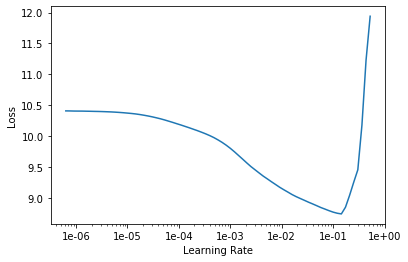

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(20, 1e-3, moms=(0.8,0.7), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='model')])

epoch,train_loss,valid_loss,accuracy,time
0,5.607016,5.545075,0.221256,25:55
1,5.001612,4.997944,0.259239,26:01
2,4.548926,4.565289,0.291202,26:09
3,4.382370,4.402876,0.302148,26:11
4,4.389576,4.357889,0.303309,26:12
5,4.228850,4.252396,0.310255,26:07
6,4.176673,4.189835,0.315705,26:10
7,4.143566,4.124595,0.320588,26:14
8,4.135462,4.051057,0.328533,26:13
9,3.985274,3.983402,0.334741,26:08


Better model found at epoch 0 with accuracy value: 0.22125616669654846.
Better model found at epoch 1 with accuracy value: 0.2592393457889557.
Better model found at epoch 2 with accuracy value: 0.291202187538147.
Better model found at epoch 3 with accuracy value: 0.30214783549308777.
Better model found at epoch 4 with accuracy value: 0.3033091127872467.
Better model found at epoch 5 with accuracy value: 0.310255229473114.
Better model found at epoch 6 with accuracy value: 0.3157047927379608.
Better model found at epoch 7 with accuracy value: 0.32058843970298767.
Better model found at epoch 8 with accuracy value: 0.3285328149795532.
Better model found at epoch 9 with accuracy value: 0.33474060893058777.
Better model found at epoch 10 with accuracy value: 0.3415887951850891.
Better model found at epoch 11 with accuracy value: 0.34962937235832214.
Better model found at epoch 12 with accuracy value: 0.35716062784194946.
Better model found at epoch 13 with accuracy value: 0.3649854362010956

In [31]:
TEXT = "जिसके लिये उन्हें "
N_WORDS = 40
N_SENTENCES = 2

In [35]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))

जिसके लिये उन्हें  ▁सही ▁कर ▁देने ▁से ▁पहले ▁कम बेस ▁की ▁आवश्यकता ▁होती ▁है । ▁x x bo s ▁अ जान जान ▁विमानक्षेत्र ▁एक ▁अ जान जान ▁धर्मशाला ▁है ▁जो ▁दक्षिण ▁एशिया ▁में ▁स्थित ▁है । ▁इसका ▁नामकरण ▁मंगोल ▁भाषा ▁के ▁अ जान
जिसके लिये उन्हें  ▁निदेशक ▁का ▁ हस ▁शेन ▁दिया ▁जाता ▁है । ▁x x bo s ▁भारतीय ▁रेलवे ▁का ▁एक ▁प्रमुख ▁रेलवे ▁स्टेशन । ▁x x bo s ▁भारत ▁के ▁ऐतिहासिक ▁एवं ▁शैक्षणिक ▁केंद्रों ▁में ▁अवस्थिति ▁की ▁दृष्टि ▁से ▁भारत ▁लिये ▁मे वाड


In [36]:
np.exp(3.549155)

34.783912659614465

In [37]:
defaults.device = torch.device('cpu')
learn.model.eval()
learn.export()

In [38]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-hindi/language-model')

In [39]:
# learn = load_learner(path / 'HindiDataset')

In [40]:
encoder = get_model(learn.model)[0]

In [41]:
encoder.state_dict()['encoder.weight'].shape

torch.Size([30000, 410])

In [42]:
embeddings = encoder.state_dict()['encoder.weight']

In [43]:
embeddings = np.array(embeddings)

In [44]:
embeddings[0].shape

(410,)

In [45]:
df = pd.DataFrame(embeddings)

In [46]:
df.shape

(30000, 410)

In [47]:
df.to_csv('transformer2_embeddings.tsv', sep='\t', index=False, header=False)

In [48]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,400,401,402,403,404,405,406,407,408,409
0,0.026936,-0.117357,-0.120443,0.065017,0.166728,-0.071703,-0.291924,-0.226281,-0.153028,-0.018027,...,0.194817,-0.072590,0.070672,-0.063407,-0.164804,0.109832,-0.060472,-0.060639,-0.072969,0.029148
1,-0.052435,-0.122068,-0.217137,-0.030436,-0.187478,-0.400876,0.065107,-0.087606,-0.270060,0.043844,...,-0.037097,0.013643,0.142191,-0.138822,-0.004607,-0.216894,0.018326,-0.265118,-0.156099,-0.165192
2,-0.052706,-0.127456,-0.216761,-0.027200,-0.182869,-0.407149,0.062482,-0.092614,-0.265342,0.042330,...,-0.025513,0.017536,0.141987,-0.138726,-0.002742,-0.214716,0.025111,-0.261457,-0.157117,-0.165897
3,0.086347,0.081104,-0.239553,-0.080807,0.012266,-0.081333,-0.273898,-0.359493,0.531257,0.199352,...,0.523504,0.049788,0.038321,-0.216122,0.044788,0.191416,-0.224508,-0.005013,0.074293,0.030674
4,-0.234804,-0.233256,-0.023235,-0.176765,-0.480278,-0.028081,-0.298427,0.017335,0.316586,-0.011410,...,-0.486305,-0.153151,-0.119705,-0.170665,-0.090154,0.081009,-0.184804,0.198799,0.147589,0.084772


In [49]:
df.shape

(30000, 410)

In [50]:
len(itos)

30000

In [51]:
df2 = pd.DataFrame(itos)

In [52]:
df2.head()

,0
0,<unk>
1,<s>
2,</s>
3,▁के
4,।


In [53]:
df2.shape

(30000, 1)

In [54]:
df2.to_csv('transformer2_embeddings_metadata.tsv', sep='\t', index=False, header=False)

In [55]:
encoder.state_dict()['encoder.weight'][1]

tensor([-5.2435e-02, -1.2207e-01, -2.1714e-01, -3.0436e-02, -1.8748e-01,
        -4.0088e-01,  6.5107e-02, -8.7606e-02, -2.7006e-01,  4.3844e-02,
        -1.4409e-01,  6.9624e-02, -2.4151e-01, -9.3456e-03, -1.0605e-01,
        -6.1454e-02, -1.5840e-01,  1.6378e-01, -1.8422e-01, -1.1712e-01,
         1.3616e-01, -2.1405e-01,  1.3627e-01,  7.0656e-02,  5.9272e-03,
        -1.7993e-01, -1.2620e-01,  1.6521e-01, -2.0209e-01,  4.1299e-02,
        -8.3203e-02,  1.5346e-01, -3.2722e-01, -1.0124e-01, -1.8463e-01,
        -6.0260e-03, -3.7177e-02,  1.0092e-01,  1.1096e-01,  6.6525e-02,
         3.4547e-01, -1.9262e-01, -1.1953e-01,  1.1277e-01, -2.3187e-02,
        -2.6035e-02, -1.4045e-01, -3.1236e-01, -6.9377e-02,  1.3386e-01,
        -1.7842e-01,  1.5998e-01, -9.7051e-02, -7.6790e-02, -1.9065e-01,
        -2.0835e-01,  1.8482e-01, -5.3779e-02,  2.9594e-01, -1.2866e-02,
         1.4117e-01, -1.4633e-01, -1.2209e-01,  4.2426e-01, -5.9861e-02,
        -1.6373e-01,  6.5469e-02, -3.7790e-01,  5.5